<a href="https://colab.research.google.com/github/HWMV/AIFFEL_Quest1/blob/master/Project/Project2/Object_Detection_UNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# R-CNN 모델

# AIFFEL 온라인 6기 코어 최현우


In [94]:
# !pip install --upgrade tensorflow
# # !pip install --upgrade tensorflow-estimator
# !pip install tensorflow-estimator==2.14.0

In [95]:
# Tensorflow와 Tensoflow Hub에 있는 이미 학습된 모델을 활용하기 위한 모듈
import tensorflow as tf
import tensorflow_hub as hub

# 이미지를 다운로드하는 데에 사용하는 모듈
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# 이미지에 선과 폰트를 넣기 위한 모듈
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# Detection하는 데에 소요된 시간을 점검하기 위한 모듈
import time

In [96]:
def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)

In [97]:
def download_and_resize_image(url, new_width=256, new_height=256, display=False):

  _, filename = tempfile.mkstemp(suffix=".jpg")
  response = urlopen(url)
  image_data = response.read()
  image_data = BytesIO(image_data)  # 이미지 읽기
  pil_image = Image.open(image_data)
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS) # 이미지 조정
  pil_image_rgb = pil_image.convert("RGB") #RBG로 변환
  pil_image_rgb.save(filename, format="JPEG", quality=90) # 이미지 저장
  print("Image downloaded to %s." % filename)
  if display:
    display_image(pil_image)
  return filename

In [98]:
# BB 만드는 함수
def draw_bounding_box_on_image(image,
                               ymin, xmin, ymax, xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):

  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)

# BBox 테두리 그리기
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]

  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height

  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin

In [99]:
# BBox 그리기
def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

# BBox 그리기 적용
  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])  # 박스 좌표값
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image


<ipython-input-97-aa2905205e73>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS) # 이미지 조정


Image downloaded to /tmp/tmp4b41eb85.jpg.


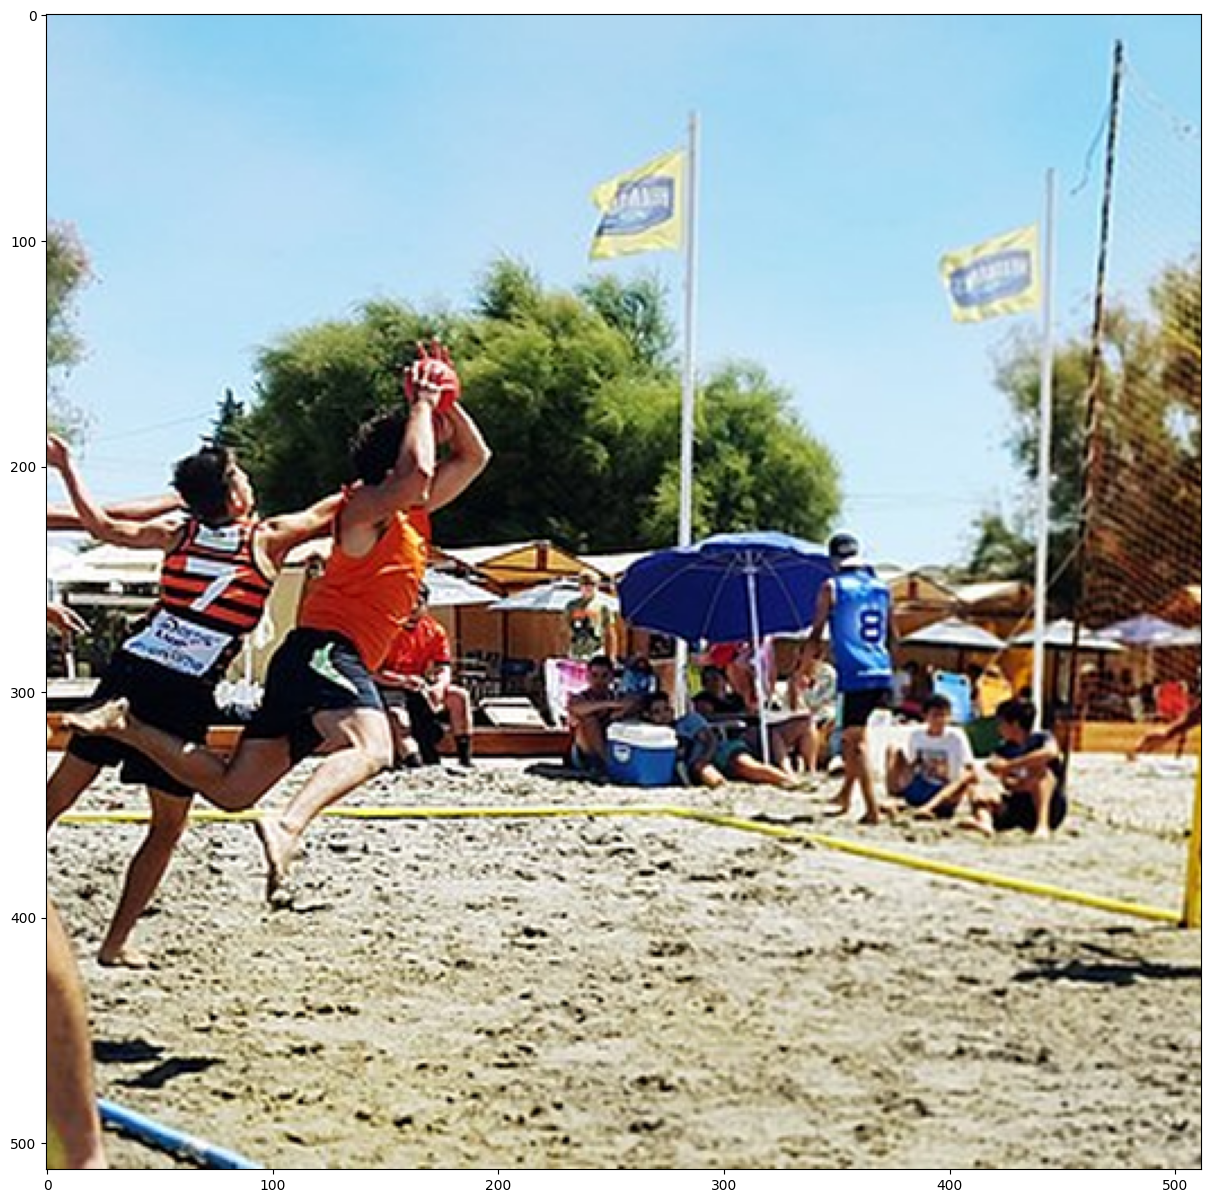

In [100]:
image_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/d/db/Torneo_beach_handball.jpg/640px-Torneo_beach_handball.jpg"
downloaded_image_path = download_and_resize_image(image_url, 512, 512, True)  # new_width와 new_height를 변경해 보세요.

In [101]:
# module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"
# U-Net module
module_handle = "https://tfhub.dev/nvidia/unet/industrial/class_1/1"
detector = hub.load(module_handle).signatures['default'] # detector에 사용할 모듈 저장

In [102]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_image(img, channels=1) # decode_jpeg 수정
  return img

In [103]:
def run_detector(detector, path):
  img = load_img(path)

  # 이미지를 모델의 입력 형식에 맞게 Resize
  img = tf.image.resize(img, (512, 512))

  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]

  result = detector(converted_img)

  result = {key: value.numpy() for key, value in result.items()}

# 소요시간 측정
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()

  result = {key:value.numpy() for key,value in result.items()}

# 이미지 추론 개수와 추론 시간 출력
  print("Found %d objects." % len(result["detection_scores"]))
  print("Inference time: ", end_time-start_time)

# 이미지 내 박스로 entity, scores를 추가하여 출력
  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"])

  display_image(image_with_boxes)

In [104]:
# 사용한 pre-trained model U-Net 입력 사이즈가 (512,512, 1) 위에서 Resize
run_detector(detector, downloaded_image_path)

KeyError: ignored

# 회고록

U-Net을 pre-trained 모델로 사용

문제점. (해당 모델 링크 : https://tfhub.dev/nvidia/unet/industrial/class_1/1)

링크 내에서 정보 확인
1. tensorflow-hub import error를 각 lib 마다 호환 버전 찾아서 업/다운 그레이드 진행 해결
2. 입/출력 형식 맞추는 것 완료
3. 모듈 서명 default 확인
4. run_detector 함수 안에서 BB로 이미지 dectection 한 시각화 코드 실패
(keyword detection_등등 찾을 수 없음)
--추후 추가 진행--

In [ ]:
# # 새로운 이미지 로드
# image_url = "https://upload.wikimedia.org/wikipedia/ko/3/37/UEFA_Women%27s_Euro_2017_Netherlands_Triumph.jpg"
# downloaded_image_path = download_and_resize_image(image_url, 1080, 656, True)  # new_width와 new_height를 변경해 보세요.

In [ ]:
# # test
# run_detector(detector, downloaded_image_path)

In [ ]:
# # 새로운 이미지 로드
# image_url = "https://upload.wikimedia.org/wikipedia/commons/1/1f/USMC-Rich_Froning_Jr.jpg"
# downloaded_image_path = download_and_resize_image(image_url, 1080, 856, True)

In [ ]:
# # U-Net pre-trained model
# import tensorflow_hub as hub
# import matplotlib.image as mpimg
# import matplotlib.pyplot as plt

# # Load the U-Net model from TensorFlow Hub
# module = hub.Module("https://tfhub.dev/nvidia/unet/industrial/class_1/1", trainable=False)

# # Load and preprocess the image
# def load_and_preprocess_image(image_path, target_size=(512, 512)):
#     img = mpimg.imread(image_path)
#     img = np.expand_dims(img, axis=0)
#     img = tf.image.resize(img, target_size)
#     img = (img - 0.5) / 0.5
#     return img

# # Function to perform image segmentation
# def perform_image_segmentation(model, image):
#     output = model(image)
#     return output

# # Image path
# image_path = 'https://upload.wikimedia.org/wikipedia/commons/1/1f/USMC-Rich_Froning_Jr.jpg'  # Replace with the path to your image

# # Load and preprocess the image
# input_image = load_and_preprocess_image(image_path)

# # Perform image segmentation
# segmentation_map = perform_image_segmentation(module, input_image)

# # Display the original image and segmentation map
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# plt.title("Original Image")
# plt.imshow(input_image[0] * 0.5 + 0.5)  # Rescale image for display
# plt.axis('off')

# plt.subplot(1, 2, 2)
# plt.title("Segmentation Map")
# plt.imshow(segmentation_map[0, ..., 0], cmap='viridis')
# plt.axis('off')

# plt.show()


In [ ]:
# image_url = "https://upload.wikimedia.org/wikipedia/commons/1/1f/USMC-Rich_Froning_Jr.jpg"